In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import cm
from scipy.io import loadmat
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.manifold import TSNE
from sklearn.svm import OneClassSVM
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import IsolationForest
from sklearn.metrics import adjusted_rand_score
from sklearn.covariance import EllipticEnvelope
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from scipy.cluster.hierarchy import dendrogram, ward
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics import silhouette_samples, silhouette_score
from imblearn.pipeline import make_pipeline as make_imb_pipeline
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import average_precision_score, precision_recall_curve
%matplotlib inline

In [6]:
data = loadmat("annthyroid.mat")
X = data['X']
y = data['y'].ravel()
fillColor = "#159726"
edgeColor = "#0A4812"

# Task 1 Visualization

### 1.1.1 Visualize the univariate distributions of all features, jointly and per class

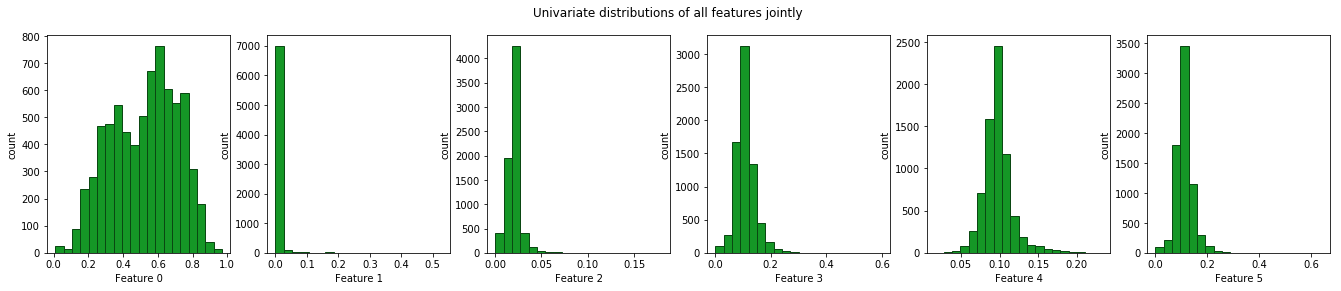

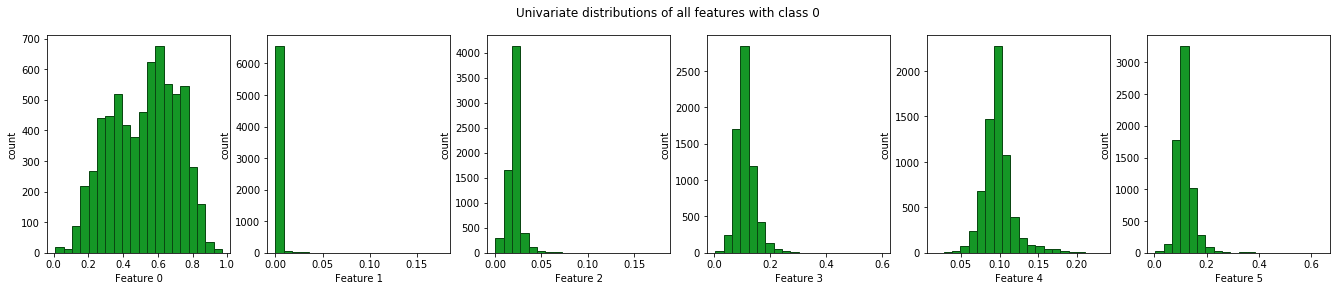

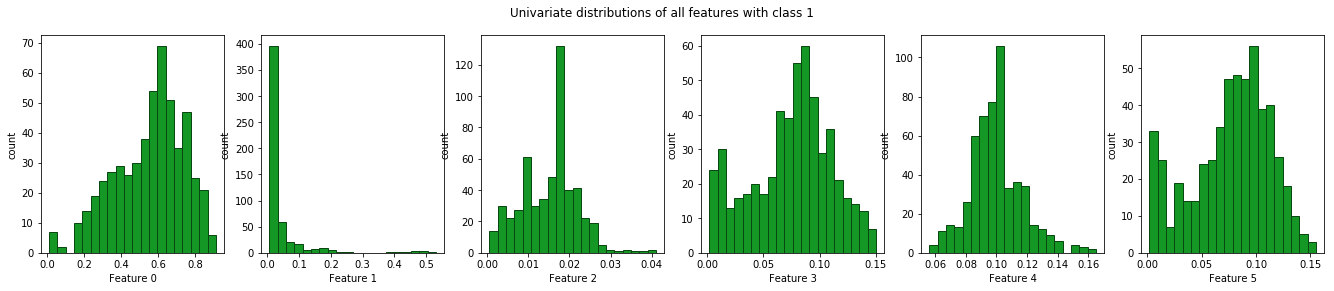

In [10]:
fig, ax = plt.subplots(1, 6, figsize = (23, 4), squeeze = False)
for i in range(0, 6):
    ax[0, i].hist(x = X[:, i], color = fillColor,
                  edgecolor = edgeColor, bins = 20)
    ax[0, i].set_xlabel("Feature " + str(i))
    ax[0, i].set_ylabel("count")
plt.suptitle("Univariate distributions of all features jointly")

fig, ax = plt.subplots(1, 6, figsize = (23, 4), squeeze = False)
for i in range(0, 6):
    ax[0, i].hist(x = X[:,[i]][y == 0], color = fillColor,
                  edgecolor = edgeColor, bins = 20)
    ax[0, i].set_xlabel("Feature " + str(i))
    ax[0, i].set_ylabel("count")
plt.suptitle("Univariate distributions of all features with class 0")
plt.show()

fig, ax = plt.subplots(1, 6, figsize = (23, 4), squeeze = False)
for i in range(0, 6):
    ax[0, i].hist(x = X[:,[i]][y == 1], color = fillColor,
                  edgecolor = edgeColor, bins = 20)
    ax[0, i].set_xlabel("Feature " + str(i))
    ax[0, i].set_ylabel("count")
plt.suptitle("Univariate distributions of all features with class 1")
plt.show()

### 1.1.2 Visualize the data using PCA

(7200, 2)


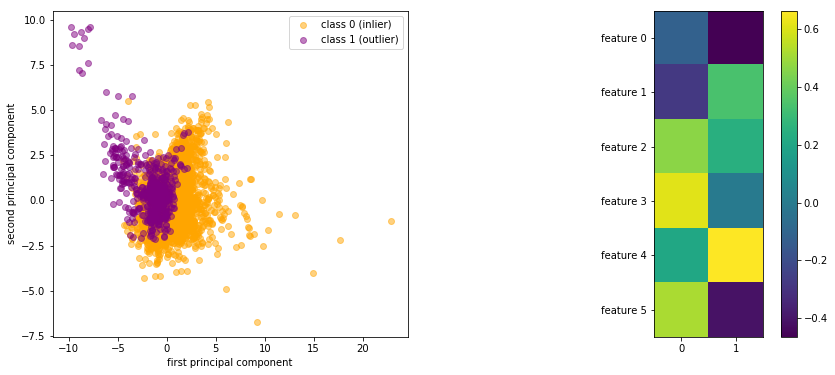

In [14]:
pca_scaled = make_pipeline(StandardScaler(), PCA(n_components = 2))
X_pca_scaled = pca_scaled.fit_transform(X)
print(X_pca_scaled.shape)

plt.figure(figsize = (14, 6))
plt.subplot(1, 2, 1)
plt.scatter(X_pca_scaled[:, 0][y == 0], X_pca_scaled[:, 1][y == 0],
            color = "orange", alpha = .5, label = "class 0 (inlier)")
plt.scatter(X_pca_scaled[:, 0][y == 1], X_pca_scaled[:, 1][y == 1],
            color = "purple", alpha = .5, label = "class 1 (outlier)")
plt.legend()
plt.xlabel("first principal component")
plt.ylabel("second principal component")

plt.subplot(1, 2, 2)
components = pca_scaled.steps[1][1].components_
plt.imshow(components.T)
plt.yticks(range(X.shape[1]), ["feature {}".format(i) for i in range(X.shape[1])])
plt.colorbar()
plt.show()

### 1.1.3 Plot the explained variance ratio in PCA

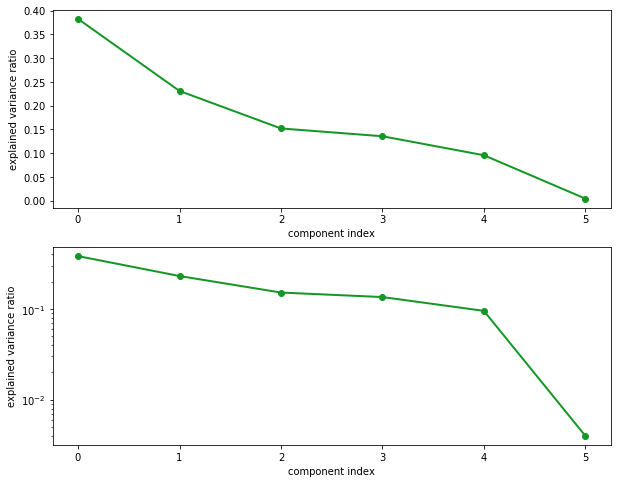

In [5]:
pca_scaled = make_pipeline(StandardScaler(), PCA(n_components = 6))
X_pca_scaled = pca_scaled.fit_transform(X)

plt.figure(figsize = (10, 8))
plt.subplot(2, 1, 1)
plt.plot(pca_scaled.steps[1][1].explained_variance_ratio_, linewidth = 2,
         marker = "o", color = fillColor)
plt.xlabel("component index")
plt.ylabel("explained variance ratio")

plt.subplot(2, 1, 2)
plt.semilogy(pca_scaled.steps[1][1].explained_variance_ratio_, linewidth = 2,
             marker = "o", color = fillColor)
plt.xlabel("component index")
plt.ylabel("explained variance ratio")
plt.show()

##### Answer:

A good threshold for the number of principal components would be 5.

### 1.2 Visualize the data using t-SNE

In [15]:
perplexity = [5, 15, 30, 60, 150, 300]
X_tsne_scaled = []
for p in perplexity:
    tsne_scaled = make_pipeline(StandardScaler(), TSNE(perplexity = p))
    X_tsne_scaled.append(tsne_scaled.fit_transform(X))

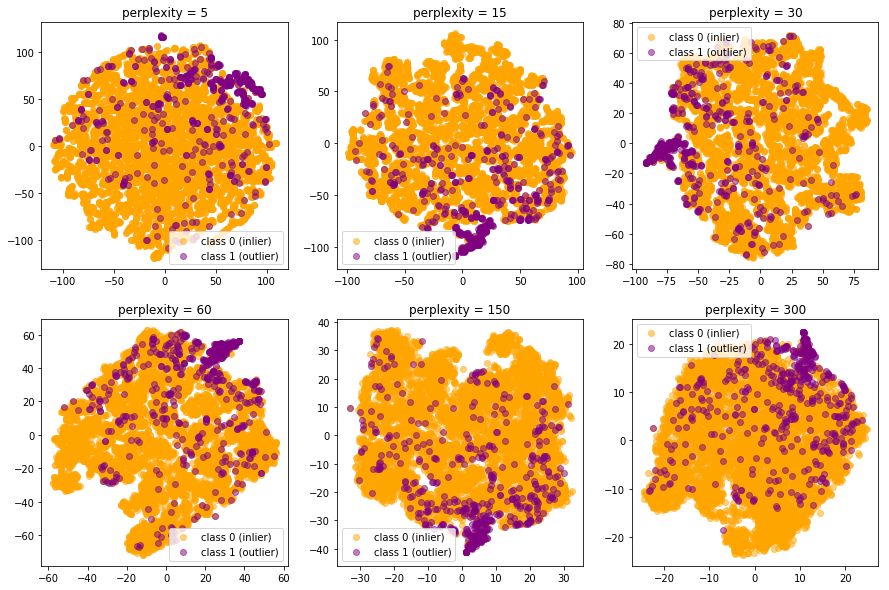

In [19]:
fig, ax = plt.subplots(2, 3, figsize = (15, 10), squeeze = False)
for i in [0, 1]:
    for j in [0, 1, 2]:
        n = 3 * i + j
        ax[i, j].scatter(X_tsne_scaled[n][:, 0][y == 0],
                         X_tsne_scaled[n][:, 1][y == 0],
                         color = "orange", alpha = .5, label = "class 0 (inlier)")
        ax[i, j].scatter(X_tsne_scaled[n][:, 0][y == 1],
                         X_tsne_scaled[n][:, 1][y == 1],
                         color = "purple", alpha = .5, label = "class 1 (outlier)")
        ax[i, j].legend()
        ax[i, j].set_title("perplexity = {}".format(perplexity[n]))
plt.show()

##### Answer:

Tuning the perplexity does not seem to help much.

# Task 2 Clustering

In [24]:
def cluster_stability(X, est, n_iter = 20, random_state = None):
    labels = []
    indices = []
    for i in range(n_iter):
        # draw bootstrap samples, store indices
        sample_indices = np.random.randint(0, X.shape[0], X.shape[0])
        indices.append(sample_indices)
        #est = clone(est)
        if hasattr(est, "random_state"):
            # randomize estimator if possible
            est.random_state = np.random.randint(1e5)
        X_bootstrap = X[sample_indices]
        est.fit(X_bootstrap)
        # store clustering outcome using original indices
        relabel = -np.ones(X.shape[0], dtype=np.int)
        relabel[sample_indices] = est.labels_
        labels.append(relabel)
    scores = []
    for l, i in zip(labels, indices):
        for k, j in zip(labels, indices):
            # we also compute the diagonal which is a bit silly
            in_both = np.intersect1d(i, j)
            scores.append(adjusted_rand_score(l[in_both], k[in_both]))
    return np.mean(scores)

In [25]:
# reference: http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhoue
# tte_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py
def measure_clustering(range_n_clusters, model):
    fig, ax = plt.subplots(1, len(range_n_clusters),
                           figsize = (12, 6), squeeze = False)
    for i in range(1):
        for j in range(len(range_n_clusters)):
            n = i * 6 + j
            n_clusters = range_n_clusters[n]
            ax[i, j].set_xlim([-0.1, 1])
            ax[i, j].set_ylim([0, len(X) + (n_clusters + 1) * 10])
            clusterer = model(n_clusters = n_clusters)
            cluster_labels = clusterer.fit_predict(X)
            silhouette_avg = silhouette_score(X, cluster_labels)
            stability = cluster_stability(X, clusterer,
                                          n_iter = 20, random_state = None)
            print("For n_clusters={}: {}".format(n_clusters,
                  np.bincount(cluster_labels)))

            sample_silhouette_values = silhouette_samples(X, cluster_labels)
            y_lower = 10
            for k in range(n_clusters):
                # Aggregate the silhouette scores for samples belonging to
                # cluster i, and sort them
                kth_cluster_silhouette_values = \
                    sample_silhouette_values[cluster_labels == k]
                kth_cluster_silhouette_values.sort()
                size_cluster_k = kth_cluster_silhouette_values.shape[0]
                y_upper = y_lower + size_cluster_k

                color = cm.spectral(float(k) / n_clusters)
                ax[i, j].fill_betweenx(np.arange(y_lower, y_upper),
                                       0, kth_cluster_silhouette_values,
                                       facecolor = color, edgecolor = color,
                                       alpha = 0.7)

                # Label the silhouette plots with their cluster numbers at the middle
                ax[i, j].text(-0.05, y_lower + 0.5 * size_cluster_k, str(k))

                # Compute the new y_lower for next plot
                y_lower = y_upper + 10  # 10 for the 0 samples

            ax[i, j].set_title("n_clusters={}\n".format(n_clusters)
                               +"score:{:.3f}\n".format(silhouette_avg)
                               +"stability:{:.3f}".format(stability))

            # The vertical line for average silhouette score of all the values
            ax[i, j].axvline(x = silhouette_avg, color = "red", linestyle = "--")

            ax[i, j].set_yticks([])  # Clear the yaxis labels / ticks
            ax[i, j].set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
            ax[i, j].get_xaxis().set_visible(False)
    plt.show()

### 2.1.1 Use KMeans to cluster the data

For n_clusters=2: [3087 4113]
For n_clusters=5: [1413 1789 1685 1007 1306]
For n_clusters=6: [1310 1422  896  866 1547 1159]
For n_clusters=7: [1272 1411  892 1083  866  171 1505]
For n_clusters=8: [1336 1021  934 1420  702  168  555 1064]
For n_clusters=9: [ 894 1473  741 1023 1345  562   21  987  154]


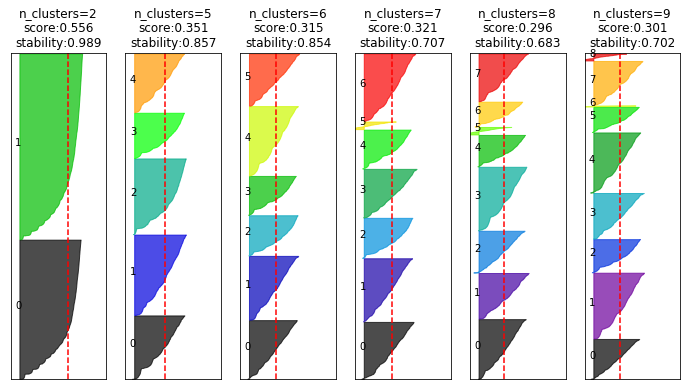

In [27]:
# extract clusters with KMeans
range_n_clusters = [2, 5, 6, 7, 8, 9]
measure_clustering(range_n_clusters, KMeans)

From above results, we think when n_clusters=7, the model could separate the outlier and inlier best. 

The corresponding Silhouette Score is 0.321 and the stability is 0.707, which are not bad compared with other scores. Also, the smallest size of clusters when n_clusters=7 is 171, which is a reasonable size for outliers because the size of the original dataset is 7200.

Although when n_clusters=2, the scores and stability are high, the size of two clusters are large, which is not a reasonable outcome for the inlier and outlier. So, it cannot identify outliers.  

### 2.1.2 Use Agglomerative Clustering to cluster the data

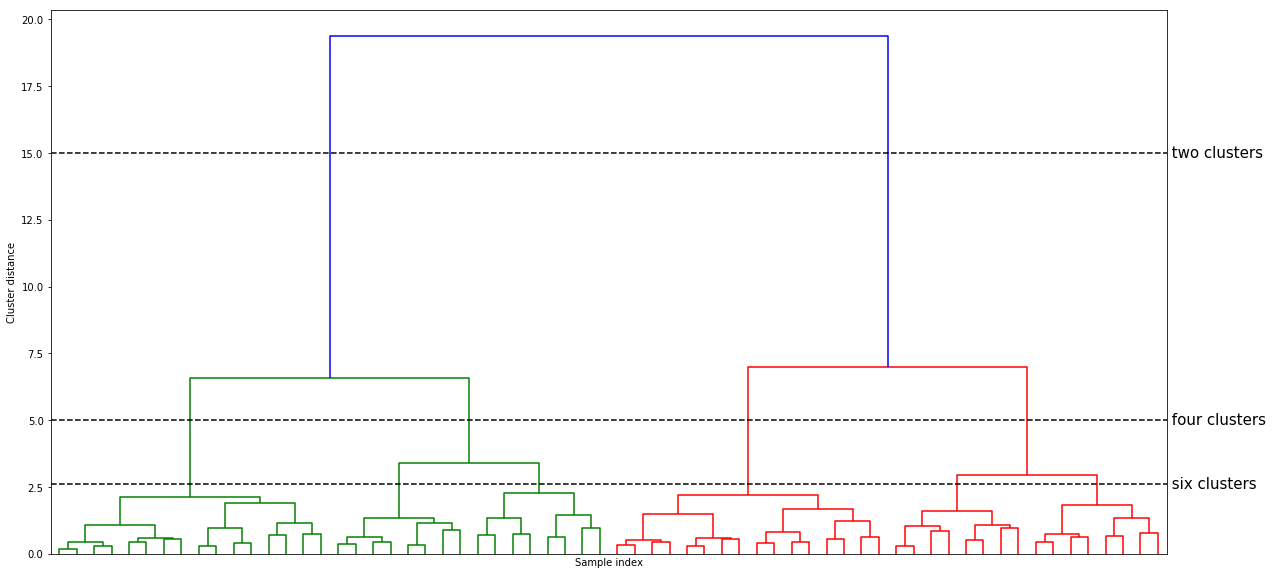

In [22]:
linkage_array = ward(X)
# now we plot the dendrogram for the linkage_array
# containing the distances between clusters
plt.figure(figsize=(20, 10))
dendrogram(linkage_array, p=5, truncate_mode='level', no_labels=True)
# Mark the cuts in the tree that signify two or three clusters
ax = plt.gca()
bounds = ax.get_xbound()
ax.plot(bounds, [15.0, 15.0], '--', c='k')
ax.plot(bounds, [5.0, 5.0], '--', c='k')
ax.plot(bounds, [2.6, 2.6], '--', c='k')
ax.text(bounds[1], 15.0, ' two clusters', va='center', fontdict={'size': 15})
ax.text(bounds[1], 5.0, ' four clusters', va='center', fontdict={'size': 15})
ax.text(bounds[1], 2.6, ' six clusters', va='center', fontdict={'size': 15})
plt.xlabel("Sample index")
plt.ylabel("Cluster distance")
plt.show()

For n_clusters=2: [4023 3177]
For n_clusters=5: [1989 1049 2034 1104 1024]
For n_clusters=6: [1049 1104 2034  962 1024 1027]
For n_clusters=7: [2034 1104 1027  962 1024  913  136]
For n_clusters=8: [1104  962 1027 1006 1024  913  136 1028]
For n_clusters=9: [ 754  962 1027 1006 1024  913  136 1028  350]


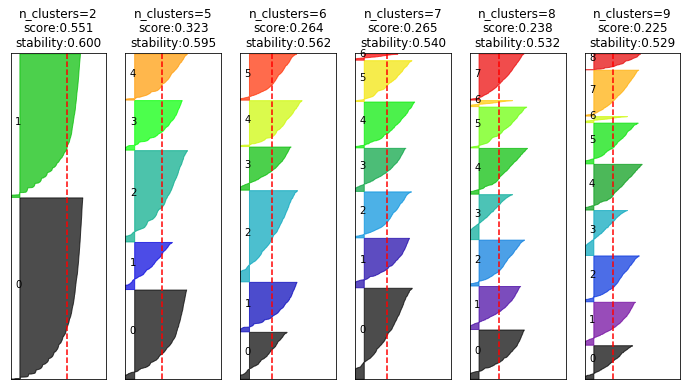

In [26]:
# extract clusters with ward agglomerative clustering
range_n_clusters = [2, 5, 6, 7, 8, 9]
measure_clustering(range_n_clusters, AgglomerativeClustering)

From results above, we conclude that n_clusters=7 is the best model for identifying outliers. 

The smallest size of clusters when n_clusters=7 is 136, which is a reasonable size for outliers because the size of the original dataset is 7200. Also, for n_clusters=[7,8,9], the cluster with size 136 always exists, which means this cluster is far away from other clusters.

### 2.1.3 Use DBSCAN to cluster the data

In [28]:
for eps in 10 ** np.linspace(-5, -1, 20):
    dbscan = DBSCAN(eps=eps, min_samples=5)
    labels = dbscan.fit_predict(X)
    print("eps: {}, Number of clusters: {}".format(eps, len(np.unique(labels))))
    print("Cluster sizes: {}\n".format(np.bincount(labels + 1)))

eps: 1e-05, Number of clusters: 10
Cluster sizes: [7142   10    6    6    5    9    5    6    6    5]

eps: 1.623776739188721e-05, Number of clusters: 10
Cluster sizes: [7142   10    6    6    5    9    5    6    6    5]

eps: 2.6366508987303556e-05, Number of clusters: 10
Cluster sizes: [7142   10    6    6    5    9    5    6    6    5]

eps: 4.281332398719396e-05, Number of clusters: 10
Cluster sizes: [7142   10    6    6    5    9    5    6    6    5]

eps: 6.951927961775606e-05, Number of clusters: 10
Cluster sizes: [7142   10    6    6    5    9    5    6    6    5]

eps: 0.00011288378916846884, Number of clusters: 10
Cluster sizes: [7142   10    6    6    5    9    5    6    6    5]

eps: 0.00018329807108324357, Number of clusters: 10
Cluster sizes: [7142   10    6    6    5    9    5    6    6    5]

eps: 0.00029763514416313193, Number of clusters: 10
Cluster sizes: [7141   10    6    7    5    9    5    6    6    5]

eps: 0.0004832930238571752, Number of clusters: 10
Cluster s

We think that eps: 0.005455594781168515, Number of clusters: 66
Cluster sizes: [6725   10    5   11    8   12    6    8    6    7    5   10   13    7
    7    9    5    8    6   14    9   11   15   10    6    7   11    5
    6    5    5    9   11   15    8    7    6    5    5    5    5    5
    6    8    5    7   11    6    5    6    8    6    4    6    7    6
    5    5    7    8    5    5    5    5    6    5] is reasonable outcome for identifying outliers. All the clusters except the one with size 6764 are regarded as outliers. So the size of outliers is 475, which is a reasonable size for outliers in this case.

### 2.2 Evaluate clustering approaches using NMI and ARI scores

In [32]:
# KMeans
clusterer = KMeans(n_clusters = 7)
cluster_labels = clusterer.fit_predict(X)
value, count = np.unique(cluster_labels, return_counts = True)
print(np.asarray((value, count)))

[[   0    1    2    3    4    5    6]
 [ 892 1410 1271  171  866 1506 1084]]


In [33]:
cluster_labels[cluster_labels != 3] = 0
print("KMeans NMI: {:.5f}".format(
        normalized_mutual_info_score(cluster_labels, y)))
print("KMeans ARI: {:.5f}".format(
        adjusted_rand_score(cluster_labels, y)))

KMeans NMI: 0.01076
KMeans ARI: -0.03330


In [34]:
# AgglomerativeClustering
clusterer = AgglomerativeClustering(n_clusters = 7)
cluster_labels = clusterer.fit_predict(X)
value, count = np.unique(cluster_labels, return_counts = True)
print(np.asarray((value, count)))

[[   0    1    2    3    4    5    6]
 [2034 1104 1027  962 1024  913  136]]


In [35]:
cluster_labels[cluster_labels != 6] = 0
print("AgglomerativeClustering NMI: {:.5f}".format(
        normalized_mutual_info_score(cluster_labels, y)))
print("AgglomerativeClustering ARI: {:.5f}".format(
        adjusted_rand_score(cluster_labels, y)))

AgglomerativeClustering NMI: 0.00934
AgglomerativeClustering ARI: -0.02788


In [36]:
# DBSCAN
clusterer = DBSCAN(eps=0.005455594781168515, min_samples=5)
cluster_labels = clusterer.fit_predict(X)
value, count = np.unique(cluster_labels, return_counts = True)
print(np.asarray((value, count)))

[[  -1    0    1    2    3    4    5    6    7    8    9   10   11   12
    13   14   15   16   17   18   19   20   21   22   23   24   25   26
    27   28   29   30   31   32   33   34   35   36   37   38   39   40
    41   42   43   44   45   46   47   48   49   50   51   52   53   54
    55   56   57   58   59   60   61   62   63   64]
 [6725   10    5   11    8   12    6    8    6    7    5   10   13    7
     7    9    5    8    6   14    9   11   15   10    6    7   11    5
     6    5    5    9   11   15    8    7    6    5    5    5    5    5
     6    8    5    7   11    6    5    6    8    6    4    6    7    6
     5    5    7    8    5    5    5    5    6    5]]


In [37]:
cluster_labels[cluster_labels != -1] = 0
print("DBSCAN NMI: {:.5f}".format(
        normalized_mutual_info_score(cluster_labels, y)))
print("DBSCAN ARI: {:.5f}".format(
        adjusted_rand_score(cluster_labels, y)))

DBSCAN NMI: 0.01638
DBSCAN ARI: -0.05947


##### Answer:

The results are bad. So, we adjust the parameters again.

In [77]:
# KMeans
max_ari = -1
max_n = 0

for n_clusters in range(1, 20):
    clusterer = KMeans(n_clusters = n_clusters)
    cluster_labels = clusterer.fit_predict(X)
    value, count = np.unique(cluster_labels, return_counts = True)
    cluster_labels[cluster_labels != np.argmin(count)] = -1
    if adjusted_rand_score(cluster_labels, y) > max_ari:
        max_ari = adjusted_rand_score(cluster_labels, y)
        max_n = n_clusters
        
clusterer = KMeans(n_clusters = max_n)
cluster_labels = clusterer.fit_predict(X)
value, count = np.unique(cluster_labels, return_counts = True)
cluster_labels[cluster_labels != np.argmin(count)] = -1
print("n_clusters: {}".format(max_n))
print("KMeans NMI: {:.5f}".format(
        normalized_mutual_info_score(cluster_labels, y)))
print("KMeans ARI: {:.5f}".format(
        adjusted_rand_score(cluster_labels, y)))

n_clusters: 10
KMeans NMI: 0.09267
KMeans ARI: 0.06166


In [78]:
# AgglomerativeClustering
max_ari = -1
max_n = 0

for n_clusters in range(1, 20):
    clusterer = AgglomerativeClustering(n_clusters = n_clusters)
    cluster_labels = clusterer.fit_predict(X)
    value, count = np.unique(cluster_labels, return_counts = True)
    cluster_labels[cluster_labels != np.argmin(count)] = -1
    if adjusted_rand_score(cluster_labels, y) > max_ari:
        max_ari = adjusted_rand_score(cluster_labels, y)
        max_n = n_clusters
        
clusterer = AgglomerativeClustering(n_clusters = max_n)
cluster_labels = clusterer.fit_predict(X)
value, count = np.unique(cluster_labels, return_counts = True)
cluster_labels[cluster_labels != np.argmin(count)] = -1
print("n_clusters: {}".format(max_n))
print("AgglomerativeClustering NMI: {:.5f}".format(
        normalized_mutual_info_score(cluster_labels, y)))
print("AgglomerativeClustering ARI: {:.5f}".format(
        adjusted_rand_score(cluster_labels, y)))

n_clusters: 10
AgglomerativeClustering NMI: 0.09204
AgglomerativeClustering ARI: 0.06730


In [80]:
# DBSCAN
max_ari = -1
max_eps = 0
max_min_samples = 0

for eps in 10 ** np.linspace(-6, 0, 50):
    for min_samples in range(1, 10):
        clusterer = DBSCAN(eps=eps, min_samples=min_samples)
        cluster_labels = clusterer.fit_predict(X)
        value, count = np.unique(cluster_labels, return_counts = True)
        cluster_labels[cluster_labels != np.argmax(count)] = -1
        if adjusted_rand_score(cluster_labels, y) > max_ari:
            max_ari = adjusted_rand_score(cluster_labels, y)
            max_eps = eps
            max_min_samples = min_samples
        
clusterer = DBSCAN(eps=max_eps, min_samples=max_min_samples)
cluster_labels = clusterer.fit_predict(X)
value, count = np.unique(cluster_labels, return_counts = True)
cluster_labels[cluster_labels != np.argmax(count)] = -1
print("eps: {}, min_samples: {}".format(max_eps, max_min_samples))
print("DBSCAN NMI: {:.5f}".format(
        normalized_mutual_info_score(cluster_labels, y)))
print("DBSCAN ARI: {:.5f}".format(
        adjusted_rand_score(cluster_labels, y)))

eps: 0.025595479226995333, min_samples: 1
DBSCAN NMI: 0.08267
DBSCAN ARI: 0.23330


##### Answer:

After we adjusted parameters, the NMI and ARI scores only increase a little. For DBSCAN, we have a much better performance. But overall, the performances are not good.

# Task 3 Outlier Detection

### 3.1.1 Use EllipticEnvelope to detect outliers

In [156]:
ratio = (y == 1).sum() / len(y)
print('The proportion of outliers is {:.3f}'.format(ratio))

The proportion of outliers is 0.074


In [157]:
# EllipticEnvelope
ee = EllipticEnvelope(contamination=ratio).fit(X)
ee_pred = ee.predict(X)
print((ee_pred == -1).mean())

0.0741666666667


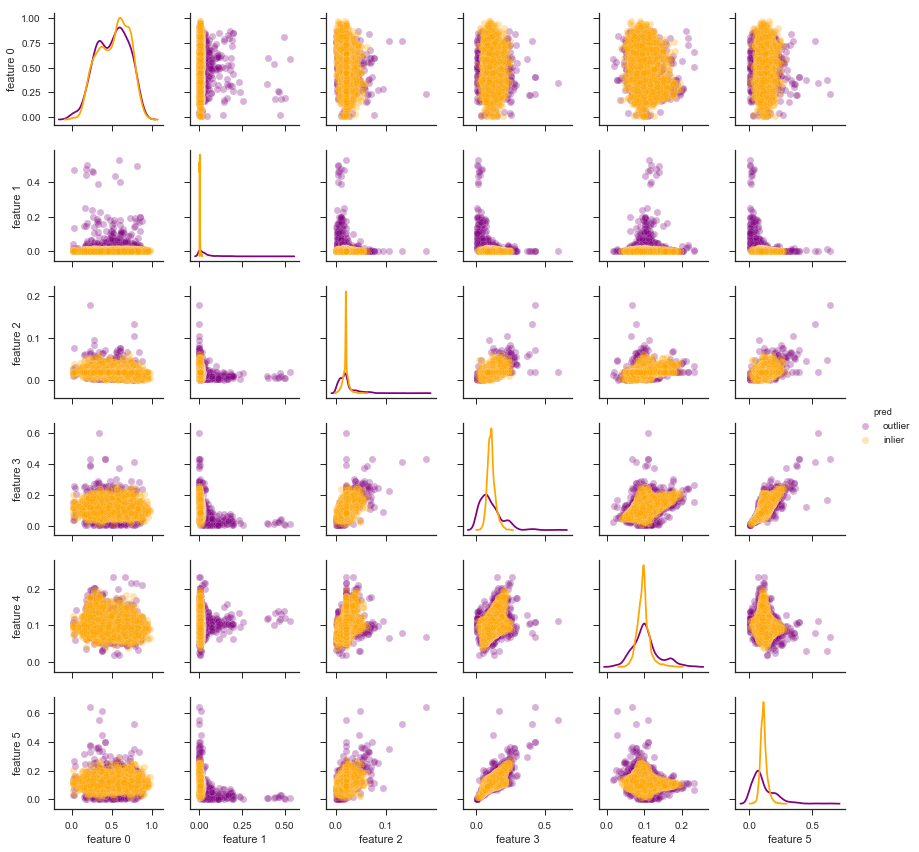

In [165]:
# create dataframe from data in X
sns.set_style("ticks")
dataframe = pd.DataFrame(X, columns=['feature {:d}'.format(i) for i in range(6)])
# create a scatter matrix from the dataframe, color by pred
dataframe['pred'] = np.array(['inlier' if i == 1 else 'outlier' for i in ee_pred])
sns.pairplot(dataframe, hue='pred', hue_order=['outlier', 'inlier'], size=2, 
             diag_kind='kde', plot_kws={'alpha': 0.3},
             palette = {"outlier": "purple", "inlier":"orange"})
plt.show()

### 3.1.2 Use OneClassSVM to detect outliers

In [166]:
# OneClassSVM
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
oneclass = OneClassSVM(nu=ratio).fit(X_scaled)
oneclass_pred = oneclass.predict(X_scaled)
print((oneclass_pred == -1).mean())

0.0745833333333


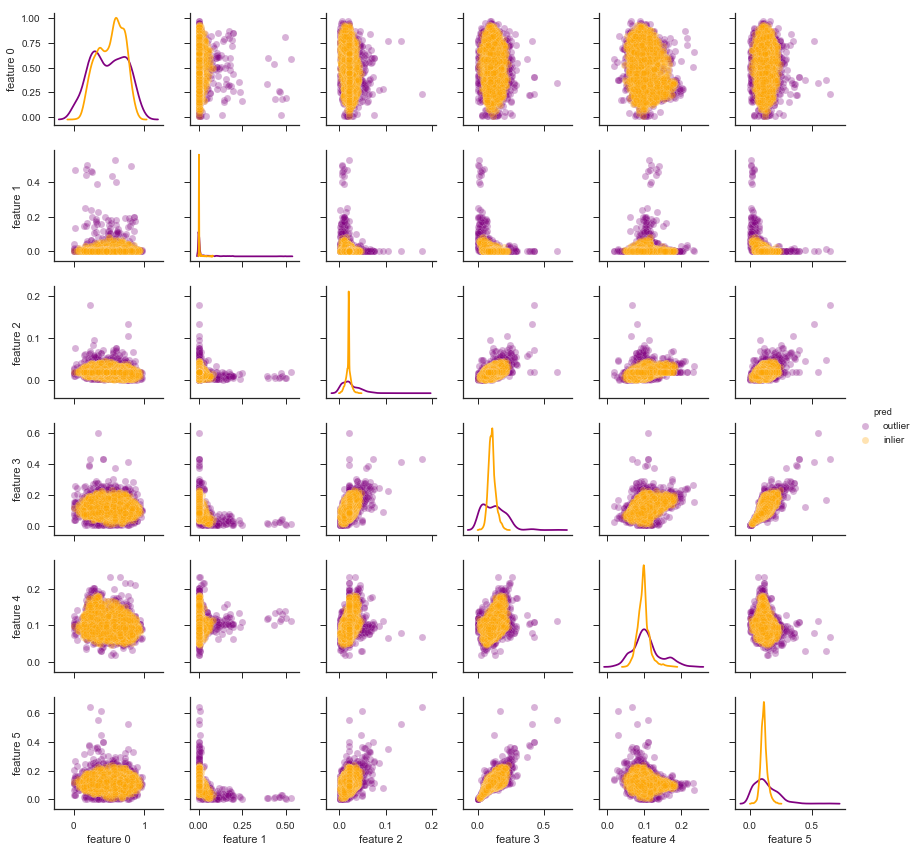

In [188]:
# create dataframe from data in X
dataframe = pd.DataFrame(X, columns=['feature {:d}'.format(i) for i in range(6)])
# create a scatter matrix from the dataframe, color by pred
dataframe['pred'] = np.array(
    ['inlier' if i == 1 else 'outlier' for i in oneclass_pred])
sns.pairplot(dataframe, hue='pred', hue_order=['outlier', 'inlier'], size=2, 
             diag_kind='kde', plot_kws={'alpha': 0.3},
             palette = {"outlier": "purple", "inlier":"orange"})
plt.show()

### 3.1.3 Use IsolationForest to detect outliers

In [170]:
# IsolationForest
isolation = IsolationForest(contamination=ratio).fit(X)
isolation_pred = isolation.predict(X)
print((isolation_pred == -1).mean())

0.0741666666667


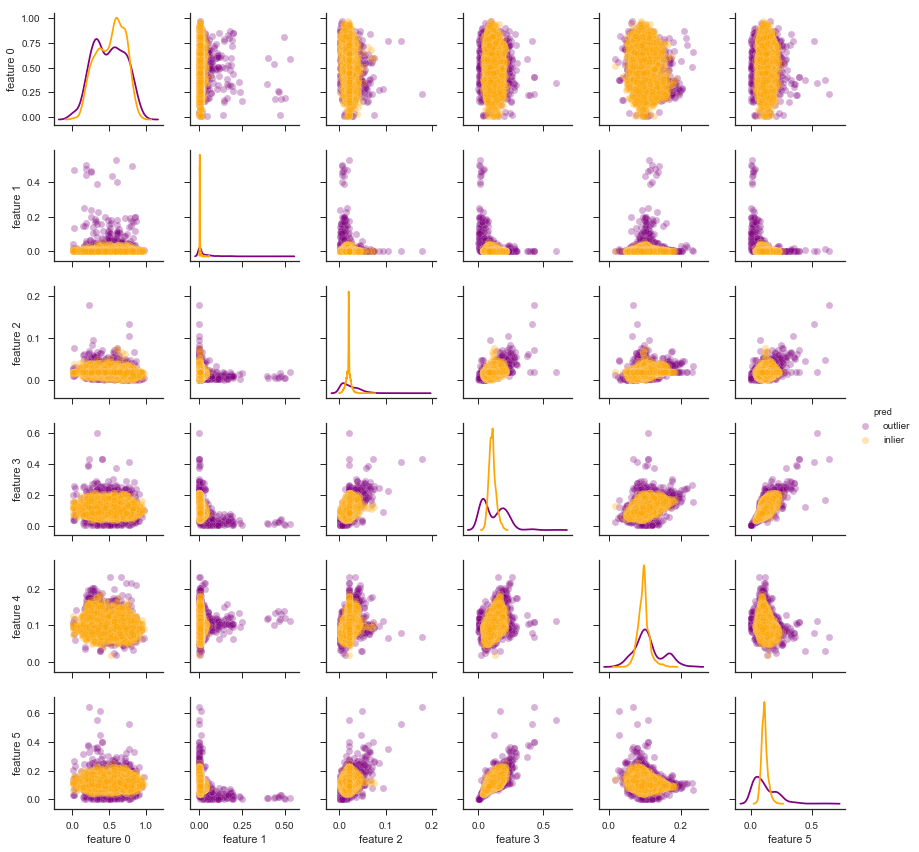

In [173]:
# create dataframe from data in X
dataframe = pd.DataFrame(X, columns=['feature {:d}'.format(i) for i in range(6)])
# create a scatter matrix from the dataframe, color by pred
dataframe['pred'] = np.array(
    ['inlier' if i == 1 else 'outlier' for i in isolation_pred])
sns.pairplot(dataframe, hue='pred', hue_order=['outlier', 'inlier'], size=2, 
             diag_kind='kde', plot_kws={'alpha': 0.3},
             palette = {"outlier": "purple", "inlier":"orange"})
plt.show()

##### Answer:

First of all, by observing inside every method, we could see that feature 1 is important in deciding whether or not the data is an inlier or an outlier.  

Then, by comparing the performances of three models detecting outliers by feature 1, we conclude which model is the best.  

We could check: given feature 1 and any other feature, which model could identify inliers and outliers best. For EllipticEnvelope method, we find that all the inliers gathers in the place where feature 1 is 0, regardless of other features, where many outliers have feature 1 greater than 0. For OneClassSVM and IsolationForest, the inliers they identify could also have feature 1 greater than 0.  

So, EllipticEnvelope is the best model.

### 3.2 Evaluate different outlier detection approaches using AUC and average precision

EllipticEnvelope roc_auc_score: 0.918
EllipticEnvelope average_precision_score: 0.504
OneClassSVM roc_auc_score: 0.489
OneClassSVM average_precision_score: 0.073
IsolationForest roc_auc_score: 0.808
IsolationForest average_precision_score: 0.341


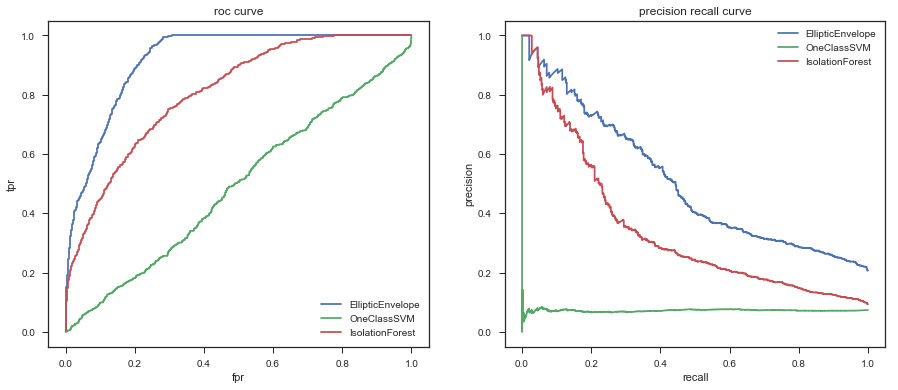

In [181]:
'''
ee.decision_function(X): 
    positive for an inlier and negative for an outlier
oneclass.decision_function(X_scaled): 
    Signed distance is positive for an inlier and negative for an outlier.
isolation.decision_function(X):
    the lower, the more abnormal
'''
models = {'EllipticEnvelope': ee, 'OneClassSVM': oneclass,
          'IsolationForest': isolation}
plt.figure(figsize = (15, 6))
for name, model in models.items():
    # roc curve
    plt.subplot(1, 2, 1)
    print('{} roc_auc_score: {:.3f}'.format(name,
                                    roc_auc_score(y,
                                    -model.decision_function(X))))
    fpr, tpr, _ = roc_curve(y, -model.decision_function(X))
    plt.plot(fpr, tpr, label=name)
    plt.xlabel('fpr')
    plt.ylabel('tpr')
    plt.title('roc curve')
    plt.legend()

    # precision recall curve
    print('{} average_precision_score: {:.3f}'.format(name,
                                        average_precision_score(y,
                                        -model.decision_function(X))))
    precision , recall, _ = precision_recall_curve(y, -model.decision_function(X))
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, label=name)
    plt.xlabel('recall')
    plt.ylabel('precision')
    plt.title('precision recall curve')
    plt.legend()
plt.show()

In [185]:
print("EllipticEnvelope NMI: {:.5f}".format(
        normalized_mutual_info_score(ee_pred, y)))
print("EllipticEnvelope ARI: {:.5f}".format(
        adjusted_rand_score(ee_pred, y)))

EllipticEnvelope NMI: 0.18126
EllipticEnvelope ARI: 0.37677


In [186]:
print("OneClassSVM NMI: {:.5f}".format(
        normalized_mutual_info_score(oneclass_pred, y)))
print("OneClassSVM ARI: {:.5f}".format(
        adjusted_rand_score(oneclass_pred, y)))

OneClassSVM NMI: 0.03718
OneClassSVM ARI: 0.14548


In [187]:
print("IsolationForest NMI: {:.5f}".format(
        normalized_mutual_info_score(isolation_pred, y)))
print("IsolationForest ARI: {:.5f}".format(
        adjusted_rand_score(isolation_pred, y)))

IsolationForest NMI: 0.09239
IsolationForest ARI: 0.24970


##### Answer: 

We compute the NMI and ARI for these three outlier detection methods and find that they are much better than the scores of the clustering methods in Task 2. So we conclude, the quality of outlier detection methods are better than Task 2.

# Task 4 Imbalanced Classification

### 4.1 Class_weight not "balanced"

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y)

### 4.1.1 LogisticRegression

In [71]:
smote_pipe_logreg = make_imb_pipeline(StandardScaler(),
                                      SMOTE(),
                                      linear_model.LogisticRegression())
param_grid = {"logisticregression__C": [0.001, 0.01, 0.1, 1, 10, 100, 1000],
              "smote__k_neighbors": [3, 5, 7, 9, 11, 15, 31]}
grid = GridSearchCV(smote_pipe_logreg, param_grid, cv = 10,
                    scoring = "roc_auc")
grid.fit(X_train, y_train)
grid.best_params_

{'logisticregression__C': 1000, 'smote__k_neighbors': 5}

In [72]:
logreg = grid.best_estimator_
scores = cross_validate(logreg, X_train, y_train, cv = 10,
                        scoring = ("roc_auc", "average_precision"))
print("LogReg ROC_AUC: {:.5f}".format(scores['test_roc_auc'].mean()))
print("LogReg Average Precision: {:.5f}".format(
    scores['test_average_precision'].mean()))

LogReg ROC_AUC: 0.98811
LogReg Average Precision: 0.81389


### 4.1.2 RandomForestClassifier

In [78]:
smote_pipe_rf = make_imb_pipeline(SMOTE(),
                                  RandomForestClassifier(n_estimators = 20))
param_grid = {"randomforestclassifier__max_depth": [3, 5, 10],
              "smote__k_neighbors": [3, 5, 7, 9, 11, 15, 31]}
grid = GridSearchCV(smote_pipe_rf, param_grid, cv = 10,
                    scoring = "roc_auc")
grid.fit(X_train, y_train)
grid.best_params_

{'randomforestclassifier__max_depth': 10, 'smote__k_neighbors': 5}

In [86]:
rf = grid.best_estimator_
scores = cross_validate(rf, X_train, y_train, cv = 10,
                        scoring = ("roc_auc", "average_precision"))
print("Random Forest ROC_AUC: {:.5f}".format(scores['test_roc_auc'].mean()))
print("Random Forest Precision: {:.5f}".format(
    scores['test_average_precision'].mean()))

Random Forest ROC_AUC: 0.99437
Random Forest Precision: 0.90274


### 4.1.3 Compare your results with the outlier detection in terms of AUC and average precision

##### Answer: 

The AUC and average precision scores for LogisticRegression and RandomForestClassifier are much better than the scores for the outlier detection methods in Task 3.

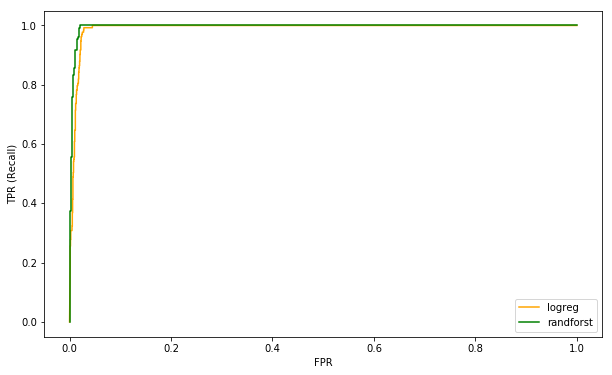

In [102]:
y_pred_lr = logreg.predict_proba(X_test)[:, 1]
y_pred_rf = rf.predict_proba(X_test)[:, 1]
fpr_lr, tpr_lr, thresholds_lr = roc_curve(
    y_test, y_pred_lr)
fpr_rf, tpr_rf, thresholds_rf = roc_curve(
    y_test, y_pred_rf)

plt.figure(figsize = (10, 6))
plt.plot(fpr_lr, tpr_lr, color = "orange", label = "logreg")
plt.plot(fpr_rf, tpr_rf, color = "green", label = "randforst")
plt.xlabel("FPR")
plt.ylabel("TPR (Recall)")
plt.legend()
plt.show()

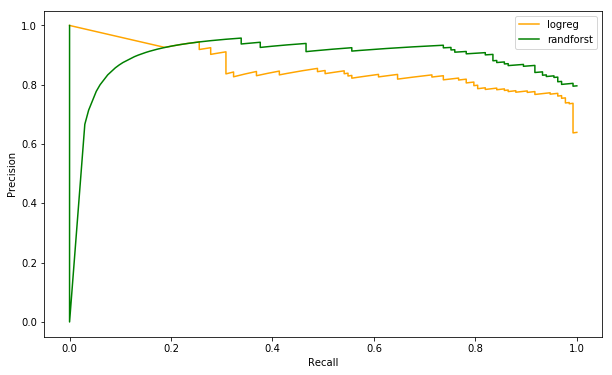

In [104]:
precision_lr, recall_lr, thresholds_lr = precision_recall_curve(
    y_test, y_pred_lr)
precision_rf, recall_rf, thresholds_rf = precision_recall_curve(
    y_test, y_pred_rf)

plt.figure(figsize = (10, 6))
plt.plot(recall_lr, precision_lr, color = "orange", label = "logreg")
plt.plot(recall_rf, precision_rf, color = "green", label = "randforst")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()

### 4.2 Class_weight "balanced"

### 4.2.1 LogisticRegression

In [105]:
smote_pipe_logreg = make_imb_pipeline(StandardScaler(),
                                      SMOTE(),
                                      linear_model.LogisticRegression(
                                          class_weight='balanced'))
param_grid = {"logisticregression__C": [0.001, 0.01, 0.1, 1, 10, 100, 1000],
              "smote__k_neighbors": [3, 5, 7, 9, 11, 15, 31]}
grid = GridSearchCV(smote_pipe_logreg, param_grid, cv = 10,
                    scoring = "roc_auc")
grid.fit(X_train, y_train)
grid.best_params_

{'logisticregression__C': 1000, 'smote__k_neighbors': 7}

In [106]:
logreg = grid.best_estimator_
scores = cross_validate(logreg, X_train, y_train, cv = 10,
                        scoring = ("roc_auc", "average_precision"))
print("LogReg ROC_AUC: {:.5f}".format(scores['test_roc_auc'].mean()))
print("LogReg Average Precision: {:.5f}".format(
    scores['test_average_precision'].mean()))

LogReg ROC_AUC: 0.98813
LogReg Average Precision: 0.81427


### 4.2.2 RandomForestClassifier

In [107]:
smote_pipe_rf = make_imb_pipeline(SMOTE(),
                                  RandomForestClassifier(n_estimators = 20,
                                            class_weight='balanced'))
param_grid = {"randomforestclassifier__max_depth": [3, 5, 10],
              "smote__k_neighbors": [3, 5, 7, 9, 11, 15, 31]}
grid = GridSearchCV(smote_pipe_rf, param_grid, cv = 10,
                    scoring = "roc_auc")
grid.fit(X_train, y_train)
grid.best_params_

{'randomforestclassifier__max_depth': 10, 'smote__k_neighbors': 31}

In [112]:
rf = grid.best_estimator_
scores = cross_validate(rf, X_train, y_train, cv = 10,
                        scoring = ("roc_auc", "average_precision"))
print("Random Forest ROC_AUC: {:.5f}".format(scores['test_roc_auc'].mean()))
print("Random Forest Precision: {:.5f}".format(
    scores['test_average_precision'].mean()))

Random Forest ROC_AUC: 0.99447
Random Forest Precision: 0.90164


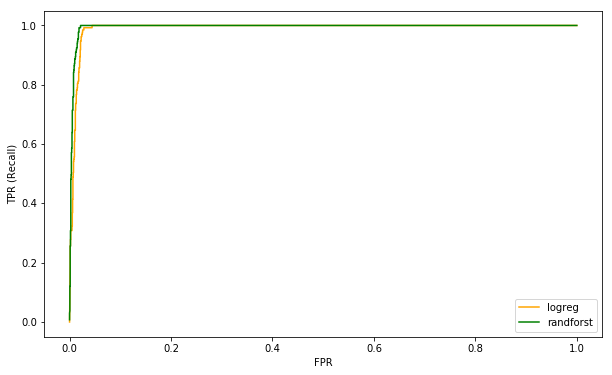

In [113]:
y_pred_lr = logreg.predict_proba(X_test)[:, 1]
y_pred_rf = rf.predict_proba(X_test)[:, 1]
fpr_lr, tpr_lr, thresholds_lr = roc_curve(
    y_test, y_pred_lr)
fpr_rf, tpr_rf, thresholds_rf = roc_curve(
    y_test, y_pred_rf)

plt.figure(figsize = (10, 6))
plt.plot(fpr_lr, tpr_lr, color = "orange", label = "logreg")
plt.plot(fpr_rf, tpr_rf, color = "green", label = "randforst")
plt.xlabel("FPR")
plt.ylabel("TPR (Recall)")
plt.legend()
plt.show()

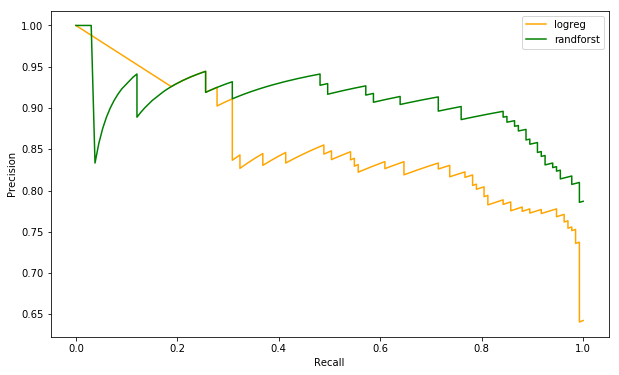

In [114]:
precision_lr, recall_lr, thresholds_lr = precision_recall_curve(
    y_test, y_pred_lr)
precision_rf, recall_rf, thresholds_rf = precision_recall_curve(
    y_test, y_pred_rf)

plt.figure(figsize = (10, 6))
plt.plot(recall_lr, precision_lr, color = "orange", label = "logreg")
plt.plot(recall_rf, precision_rf, color = "green", label = "randforst")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()

##### Answer:

Changing the class-weight to "balanced" doesn't seem to help much.